<a href="https://colab.research.google.com/github/Samlebrize/P07/blob/main/P07_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import modules

In [ ]:
!pip install pyLDAvis==2.1.2

#if np.iscomplexobj(obj):
#        return abs(obj)

# To usr/local/lib/python3.7/dist_package/pyLDAvis/utils.py

In [ ]:
#pip install pandas --upgrade

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import scipy.stats as st
import random
import glob, os
import missingno as msno
import pickle
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',200)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
warnings.filterwarnings('ignore')
import re, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report
import nltk
nltk.download('all')
import re
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import numpy as np
import tqdm
import gensim
import time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier


### Requêtes SQL

#1. Analyse, Cleaning & Feature engineering

### 1.1 Import fichier

In [ ]:
import glob
all_files = glob.glob("/content/drive/MyDrive/Colab_Notebooks/P06/CSV/QueryResults" + "*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename,sep = ',',error_bad_lines=False, index_col=None, header=0)
    li.append(df)

df_cc = pd.concat(li, axis=0, ignore_index=True)

### 1.2 Analyse et clean des Tags

In [ ]:
df_cc['Tags']

0                                                     <c++>
1                                               <html><css>
2                                     <arrays><c><function>
3                                   <r><ggplot2><tidyverse>
4                                                     <c++>
                                ...                        
249995                             <php><command-line><zip>
249996                  <c#><winforms><tabcontrol><tabpage>
249997                              <php><zip><large-files>
249998    <oop><functional-programming><paradigms><proce...
249999                                             <syntax>
Name: Tags, Length: 250000, dtype: object

In [ ]:
def clean_alt_list(list_):
  list_ = list_[1:]
  list_ = list_[:-1]
  list_ = list_.split("><")
  return list_

In [ ]:
df_cc['Tags'] = [clean_alt_list(df_cc['Tags'][i]) for i in df_cc.index]
df_cc.drop(index = df_cc[[df_cc['Tags'][i]==[] for i in df_cc['Tags'].index]].index.tolist(), inplace=True)

In [ ]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

All_tags = to_1D(df_cc['Tags']).value_counts()
All_tags_df = pd.DataFrame(data=All_tags)

All_tags_df.sort_values(0,ascending=False,inplace=True)
print(All_tags_df.head(10))
print(All_tags_df.tail(10))

                0
java        31331
javascript  29263
python      25336
c#          21382
php         18284
c++         16780
html        14659
android     12549
css         11158
jquery       9917
                        0
kotlin-generics         1
cellid                  1
servicestack-bsd        1
active-directory-group  1
spring-security-rest    1
openimaj                1
k-fold                  1
dynamic-jasper          1
radix-tree              1
ext2                    1


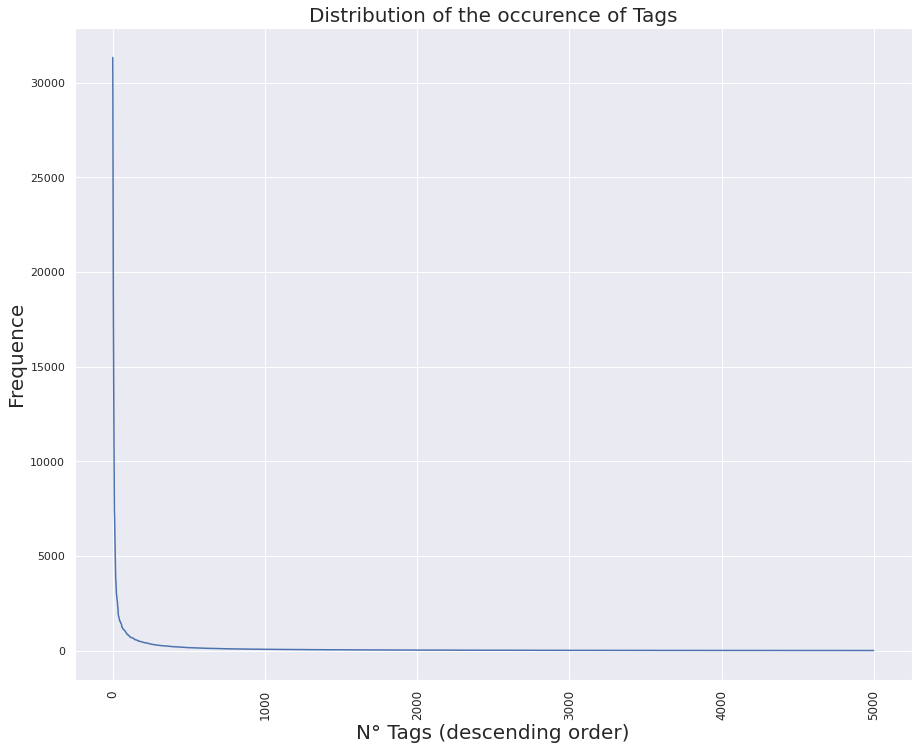

In [ ]:
All_tags_df['H'] = np.arange(0,len(All_tags_df.index.tolist()),1)
All_tags_df_100 = All_tags_df.head(5000)
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize = (15,12))
ax.set_ylabel("Frequence", size = 20)
plt.xticks(rotation=90, size = 12)
ax.set_xlabel("N° Tags (descending order)", size = 20)
ax.set_title("Distribution of the occurence of Tags", size = 20)
sns.lineplot(x="H", y=0, data=All_tags_df_100)

Ce tableau nous permet d'apprécier comment se répartissent les occurences des divers tags, on peut voir que peu de tags sortent de très nombreuses fois tanding qu'une très grande partie d'entre eux, seulement quelques fois.

In [ ]:
All_tags_df_100[All_tags_df_100[0]>20].tail()

0     H
css-tables          21  2779
gateway             21  2780
linear-programming  21  2781
git-submodules      21  2782
avx                 21  2783

Nous pouvons voir que dès le 2778ème tag, il n'y a plus que 20 occurences ou moins de ceux ci,

In [ ]:
lim_tags = All_tags_df_100[All_tags_df_100[0]>20].tail().iloc[4,1]

Nous nous limitons aux tags d'une occurence minimale de 20 pour ne pas générer trop de bruits dans nos modèles, nous allons supprimer ces lignes

In [ ]:
list_tags = All_tags_df[0:lim_tags].index.tolist()
list_tags = simple_preprocess(str(list_tags))

df_cc['Tags'] = [[word for word in simple_preprocess(str(doc)) if word in list_tags] for doc in df_cc['Tags']]

#Drop nouvelles lignes vides
df_cc.drop(index = df_cc[[df_cc['Tags'][i]==[] for i in df_cc['Tags'].index]].index.tolist(), inplace=True)

In [ ]:
df_cc[[df_cc['Tags'][i]==[] for i in df_cc['Tags'].index]][['Title','Tags']]

Empty DataFrame
Columns: [Title, Tags]
Index: []

In [ ]:
df_cc['lenT'] = [len(df_cc.Tags[i]) for i in df_cc.index]

In [ ]:
print('Nb of questions with more than 5 Taggs :',len(df_cc[df_cc['lenT']>5]))
print('-'*100)
print('Nb of questions in the file : ',len(df_cc))

Nb of questions with more than 5 Taggs : 19967
----------------------------------------------------------------------------------------------------
Nb of questions in the file :  240241


In [ ]:
df_cc.AnswerCount.value_counts(dropna=False)

1      107191
2       60698
3       32247
4       16645
5        8984
6        5124
7        2981
8        1848
9        1206
10        842
11        547
12        433
13        308
14        221
15        191
16        141
17        103
18         86
19         69
20         57
21         46
22         38
23         28
27         25
25         22
24         21
31         21
30         18
26         18
34         12
29         10
28          6
37          6
32          5
41          4
43          4
35          3
38          3
40          3
33          3
45          3
48          2
36          2
54          2
195         1
80          1
77          1
72          1
70          1
68          1
163         1
59          1
49          1
46          1
87          1
42          1
39          1
100         1
Name: AnswerCount, dtype: int64

La majeur partie des posts n'ont que peut de réponses.ce qui est cohérent.

In [ ]:
df_cc.Score.value_counts(dropna=False).head(20)

1     89346
2     46638
3     24523
4     14875
5      9905
6      7012
7      5364
8      4255
9      3397
10     2835
11     2365
12     2116
13     1727
14     1573
15     1378
16     1275
17     1095
18     1039
19      946
20      809
Name: Score, dtype: int64

Nous avons observé plus haut la distribution des scores sur notre échantillon de questions. Il est intéressant de ploter cette information avec la longueur 

Plot des score (log) en fonction du nombre de tags dans le post

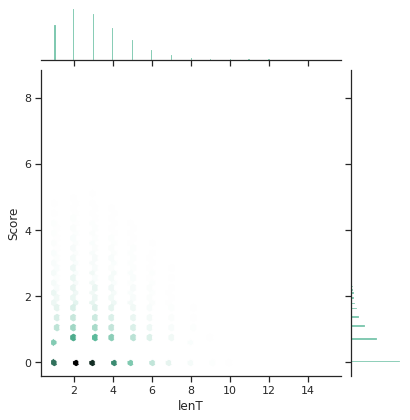

In [ ]:
sns.set_theme(style="ticks")
x = df_cc['lenT']
y = np.log(df_cc['Score'])
sns.jointplot(x=x, y=y, kind="hex", color="#4CB391")

In [ ]:
df_cc = df_cc[df_cc.lenT > 3]
df_cc = df_cc[df_cc.lenT < 6]
len(df_cc)

62238

Nous supprimons les questions dont le nombre de tags est trop élevé (>5) étant donné qu'aujourd'hui nous n'avons plus de questions avec plus de 5 tags, cela ne concerne que 10% des posts encore dans le fichier, et cela n'est potentiellement qu'un test sur une période limité du site car cela ne concerne pas les derniers posts.

Aussi nous ne gardons que les questions qui ont un minimum de 4 tags, car elles apportent plus d'information, et il nous faut réduire la taille du dataset pour alléger la charge de calcul.

### 1.3 Train / Test Split

In [ ]:
df, df_test = train_test_split(df_cc, test_size=0.2, random_state=1)

### 1.4 Feature Engeniring Body (Step by Step)

In [ ]:
df.reset_index(inplace = True)
df.Body[0]

'<p>I think <a href="https://stackoverflow.com/questions/7138780/move-semantics-returning-const-values">this question</a> was slightly misunderstood.</p>\n\n<p>Returning <code>const</code> values is not something that can be dismissed as meaningless. As Adam Burry pointed out in a comment, Scott Meyers recommends it in <em>More Effective C++</em> (Item 6), to which I would add Herb Sutter\'s <em>Exceptional C++</em> (Item 20, Class Mechanics, whose corresponding GotW is <a href="http://www.gotw.ca/gotw/004.htm" rel="nofollow noreferrer">available online</a>).</p>\n\n<p>The rationale for doing this is that you want the compiler to catch typos like <code>(a+b)=c</code> (oops, meant <code>==</code>), or misleading statements like <code>a++++</code>, both of which are flagged out-of-the-box for primitive types like <code>int</code>. So for stuff like <code>operator+</code> and <code>operator++(int)</code>, returning a <code>const</code> value does make sense.</p>\n\n<p>On the other hand, a

#### BeautifulSoup

In [ ]:
soup = BeautifulSoup(df.Body[42])
#soup.p.text
for p in soup.find_all('p'):
    print(p.text)

Is there a tool that will convert MS Access SQL to T-SQL? 


In [ ]:
docs = df.Body
docs = [(BeautifulSoup(doc).find_all('p')) for doc in docs]
docs = [[phrase.text for phrase in doc] for doc in docs]
docs = [" ".join(doc) for doc in docs]
df['descr'] = docs

In [ ]:
df['descr']

0        I think this question was slightly misundersto...
1        I have two arrays in a bash script, every arra...
2        I am working with jQuery Spritely plugin for m...
3        Usually, there is only one instance of a speci...
4        Here's my code but my answer is not that which...
                               ...                        
49785    We've recently upgraded (migration path) from ...
49786    I've made a php-page where you can upload imag...
49787    I'm basically trying to loop through the array...
49788    Following Code:  The Error gives me:  Argument...
49789    I have a window with the following appearance:...
Name: descr, Length: 49790, dtype: object

##### Comparaison 

In [ ]:
df.Body[28]

"<p>I'd like to use Python to build a website with more than 100,000 PV each day. Now what I concern is to choose which web framework. I know lots of people use Django, and some people use web.py. Django seems powerful, and I also like the simplicity of web.py. Which framework should I use? (Please introduce the performance and the maintenance complexity, thanks!) Can web.py build complicated applications? Are there other frameworks better than these two?</p>\n"

In [ ]:
df['descr'][28]

"I'd like to use Python to build a website with more than 100,000 PV each day. Now what I concern is to choose which web framework. I know lots of people use Django, and some people use web.py. Django seems powerful, and I also like the simplicity of web.py. Which framework should I use? (Please introduce the performance and the maintenance complexity, thanks!) Can web.py build complicated applications? Are there other frameworks better than these two?"

#### Lowercase

In [ ]:
df['descr'] = [doc.lower() for doc in df['descr']]

In [ ]:
df['descr'][28]

"i'd like to use python to build a website with more than 100,000 pv each day. now what i concern is to choose which web framework. i know lots of people use django, and some people use web.py. django seems powerful, and i also like the simplicity of web.py. which framework should i use? (please introduce the performance and the maintenance complexity, thanks!) can web.py build complicated applications? are there other frameworks better than these two?"

#### Word tokenization

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['descr1'] = [tokenizer.tokenize(doc) for doc in df['descr']]

In [ ]:
df['descr1'][28]

['i',
 'd',
 'like',
 'to',
 'use',
 'python',
 'to',
 'build',
 'a',
 'website',
 'with',
 'more',
 'than',
 '100',
 '000',
 'pv',
 'each',
 'day',
 'now',
 'what',
 'i',
 'concern',
 'is',
 'to',
 'choose',
 'which',
 'web',
 'framework',
 'i',
 'know',
 'lots',
 'of',
 'people',
 'use',
 'django',
 'and',
 'some',
 'people',
 'use',
 'web',
 'py',
 'django',
 'seems',
 'powerful',
 'and',
 'i',
 'also',
 'like',
 'the',
 'simplicity',
 'of',
 'web',
 'py',
 'which',
 'framework',
 'should',
 'i',
 'use',
 'please',
 'introduce',
 'the',
 'performance',
 'and',
 'the',
 'maintenance',
 'complexity',
 'thanks',
 'can',
 'web',
 'py',
 'build',
 'complicated',
 'applications',
 'are',
 'there',
 'other',
 'frameworks',
 'better',
 'than',
 'these',
 'two']

#### Removing Stopwords

In [ ]:
stop_words=set(stopwords.words("english"))
stop_words=simple_preprocess(str(stop_words))

filename7 = '/content/drive/MyDrive/Colab_Notebooks/P06/stopwords.pkl'
pickle.dump(stop_words, open(filename7, 'wb'))

df['descr1'] = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in df['descr1']]

#### Lematize / Stemming

In [ ]:
lem = WordNetLemmatizer()
stem = PorterStemmer()

word = "apples"
print("Lemmatized Word:",lem.lemmatize(word))
print("Stemmed Word:",stem.stem(word))

Lemmatized Word: apple
Stemmed Word: appl


##### Test

In [ ]:
print(df['descr1'][28])

['like', 'use', 'python', 'build', 'website', 'pv', 'day', 'concern', 'choose', 'web', 'framework', 'know', 'lots', 'people', 'use', 'django', 'people', 'use', 'web', 'py', 'django', 'seems', 'powerful', 'also', 'like', 'simplicity', 'web', 'py', 'framework', 'use', 'please', 'introduce', 'performance', 'maintenance', 'complexity', 'thanks', 'web', 'py', 'build', 'complicated', 'applications', 'frameworks', 'better', 'two']


In [ ]:
documents = df['descr1'][28]
documents = [stem.stem(word) for sentence in documents for word in sentence.split(" ")]
documents

['like',
 'use',
 'python',
 'build',
 'websit',
 'pv',
 'day',
 'concern',
 'choos',
 'web',
 'framework',
 'know',
 'lot',
 'peopl',
 'use',
 'django',
 'peopl',
 'use',
 'web',
 'py',
 'django',
 'seem',
 'power',
 'also',
 'like',
 'simplic',
 'web',
 'py',
 'framework',
 'use',
 'pleas',
 'introduc',
 'perform',
 'mainten',
 'complex',
 'thank',
 'web',
 'py',
 'build',
 'complic',
 'applic',
 'framework',
 'better',
 'two']

##### Transformation

In [ ]:
df['d_lemmatized'] = df['descr1']
df['d_stemmed'] = df['descr1']


df['d_lemmatized'] = [[lem.lemmatize(token) for token in doc] for doc in df['d_lemmatized']]
df['d_stemmed'] = [[stem.stem(token) for token in doc] for doc in df['d_stemmed']]

In [ ]:
df['d_lemmatized']

0        [think, question, slightly, misunderstood, ret...
1        [two, array, bash, script, every, array, numbe...
2        [working, jquery, spritely, plugin, moving, cl...
3        [usually, one, instance, specific, servlet, co...
4        [code, answer, want, please, check, give, solu...
                               ...                        
49785    [recently, upgraded, migration, path, tfs, sha...
49786    [made, php, page, upload, image, file, saved, ...
49787    [basically, trying, loop, array, substracting,...
49788    [following, code, error, give, argument, type,...
49789    [window, following, appearance, would, like, h...
Name: d_lemmatized, Length: 49790, dtype: object

In [ ]:
df['d_stemmed']

0        [think, question, slightli, misunderstood, ret...
1        [two, array, bash, script, everi, array, numbe...
2        [work, jqueri, sprite, plugin, move, cloud, an...
3        [usual, one, instanc, specif, servlet, contain...
4        [code, answer, want, pleas, check, give, solut...
                               ...                        
49785    [recent, upgrad, migrat, path, tf, sharepoint,...
49786    [made, php, page, upload, imag, file, save, da...
49787    [basic, tri, loop, array, substract, first, el...
49788    [follow, code, error, give, argument, type, er...
49789    [window, follow, appear, would, like, howev, b...
Name: d_stemmed, Length: 49790, dtype: object

##### Comparaison

In [ ]:
df['descr1'][28]

['like',
 'use',
 'python',
 'build',
 'website',
 'pv',
 'day',
 'concern',
 'choose',
 'web',
 'framework',
 'know',
 'lots',
 'people',
 'use',
 'django',
 'people',
 'use',
 'web',
 'py',
 'django',
 'seems',
 'powerful',
 'also',
 'like',
 'simplicity',
 'web',
 'py',
 'framework',
 'use',
 'please',
 'introduce',
 'performance',
 'maintenance',
 'complexity',
 'thanks',
 'web',
 'py',
 'build',
 'complicated',
 'applications',
 'frameworks',
 'better',
 'two']

In [ ]:
df['d_lemmatized'][28]

['like',
 'use',
 'python',
 'build',
 'website',
 'pv',
 'day',
 'concern',
 'choose',
 'web',
 'framework',
 'know',
 'lot',
 'people',
 'use',
 'django',
 'people',
 'use',
 'web',
 'py',
 'django',
 'seems',
 'powerful',
 'also',
 'like',
 'simplicity',
 'web',
 'py',
 'framework',
 'use',
 'please',
 'introduce',
 'performance',
 'maintenance',
 'complexity',
 'thanks',
 'web',
 'py',
 'build',
 'complicated',
 'application',
 'framework',
 'better',
 'two']

In [ ]:
df['d_stemmed'][28]

['like',
 'use',
 'python',
 'build',
 'websit',
 'pv',
 'day',
 'concern',
 'choos',
 'web',
 'framework',
 'know',
 'lot',
 'peopl',
 'use',
 'django',
 'peopl',
 'use',
 'web',
 'py',
 'django',
 'seem',
 'power',
 'also',
 'like',
 'simplic',
 'web',
 'py',
 'framework',
 'use',
 'pleas',
 'introduc',
 'perform',
 'mainten',
 'complex',
 'thank',
 'web',
 'py',
 'build',
 'complic',
 'applic',
 'framework',
 'better',
 'two']

#### Tagging for Verbs and Nouns on Lematize

In [ ]:
text = df['descr1'][28]
nltk.pos_tag(text)

[('like', 'IN'),
 ('use', 'NN'),
 ('python', 'NN'),
 ('build', 'VBP'),
 ('website', 'JJ'),
 ('pv', 'NN'),
 ('day', 'NN'),
 ('concern', 'NN'),
 ('choose', 'VBP'),
 ('web', 'NN'),
 ('framework', 'NN'),
 ('know', 'VBP'),
 ('lots', 'NNS'),
 ('people', 'NNS'),
 ('use', 'VBP'),
 ('django', 'JJ'),
 ('people', 'NNS'),
 ('use', 'VBP'),
 ('web', 'JJ'),
 ('py', 'NN'),
 ('django', 'NN'),
 ('seems', 'VBZ'),
 ('powerful', 'JJ'),
 ('also', 'RB'),
 ('like', 'VBP'),
 ('simplicity', 'NN'),
 ('web', 'VBP'),
 ('py', 'NN'),
 ('framework', 'NN'),
 ('use', 'NN'),
 ('please', 'NN'),
 ('introduce', 'VB'),
 ('performance', 'NN'),
 ('maintenance', 'NN'),
 ('complexity', 'NN'),
 ('thanks', 'NNS'),
 ('web', 'VBP'),
 ('py', 'JJ'),
 ('build', 'NN'),
 ('complicated', 'VBD'),
 ('applications', 'NNS'),
 ('frameworks', 'NNS'),
 ('better', 'RBR'),
 ('two', 'CD')]

In [ ]:
docs = df['d_lemmatized']
docs = [[wt[0] for wt in nltk.pos_tag(doc) if re.match('VB',wt[1]) and wt[1]!='VBZ' or wt[1]=='NN']for doc in docs]
df['d_lemmatized2'] = docs

In [ ]:
df['d_lemmatized2']

0        [think, question, misunderstood, returning, co...
1        [array, bash, script, array, number, element, ...
2        [working, jquery, moving, animation, worked, j...
3        [instance, servlet, container, servlet, get, r...
4        [code, answer, want, please, check, solution, ...
                               ...                        
49785    [upgraded, migration, path, tfs, sharepoint, t...
49786    [made, page, image, file, saved, database, typ...
49787    [trying, array, substracting, append, result, ...
49788    [following, code, error, give, argument, type,...
49789    [window, following, appearance, like, button, ...
Name: d_lemmatized2, Length: 49790, dtype: object

### 1.5 Feature Engeniring Title

In [ ]:
## Function to put into format numerous docs at a single time

def formating_the_corpus(docs):
  from gensim.utils import simple_preprocess
  #Get all 'p' text from doc and cocnatenate it
  docs = [(BeautifulSoup(doc).find_all('p')) for doc in docs]
  docs = [[phrase.text for phrase in doc] for doc in docs]
  docs = [" ".join(doc) for doc in docs]
  # Lowering
  docs = [doc.lower() for doc in docs]
  # Tokenizing
  tokenizer = RegexpTokenizer(r'\w+')
  docs = [tokenizer.tokenize(doc) for doc in docs]
  # Removing stop words and most frequent ones
  stop_words=set(stopwords.words("english"))
  stop_words = simple_preprocess(str(stop_words))
  docs = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in docs]
  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  docs = [[wt[0] for wt in nltk.pos_tag(doc) if re.match('VB',wt[1]) and wt[1]!='VBZ' or wt[1]=='NN']for doc in docs]
  docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
  return docs

## Function to put a single entry into format
def formating_the_doc(doc):
  from gensim.utils import simple_preprocess
  doc = BeautifulSoup(doc).find_all('p')
  doc = [phrase.text for phrase in doc]
  doc = " ".join(doc)
  # Lowering
  doc = doc.lower()
  # Tokenizing
  tokenizer = RegexpTokenizer(r'\w+')
  doc = tokenizer.tokenize(doc)
  # Removing stop words and most frequent ones
  stop_words=set(stopwords.words("english"))
  stop_words=simple_preprocess(str(stop_words))
  doc = [word for word in simple_preprocess(str(doc)) if word not in stop_words]
  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  doc = [lemmatizer.lemmatize(token) for token in doc]
  return doc
#docs = [formating_the_doc(doc) for doc in docs]


In [ ]:
df['Tit_lemmatized2'] = formating_the_corpus(df['Title'])

In [ ]:
df['Title'][0]

'Returning const values to leverage move semantics vs preventing stuff like (a+b)=c'

In [ ]:
df['Tit_lemmatized2'][0]

['returning', 'const', 'value', 'leverage', 'move', 'preventing', 'stuff']

### 1.6 Feature engineering Test set

In [ ]:
df_test['Tit_lemmatized2'] = formating_the_corpus(df_test['Title'])
df_test['d_lemmatized2'] = formating_the_corpus(df_test['Body'])

# 2. Modélisation Non supervisée LDA (Gensim)

## 2.1 Création / Recherche du modèle optimum

### Définition Corpus, Dictionnaire, et mesure de performance

In [ ]:
df['BOW'] = df['Tit_lemmatized2'] + df['d_lemmatized2']

In [ ]:
data_lemmatized = df['Tit_lemmatized2']

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=10, no_above=0.50)

# Create Corpus
texts = df['BOW']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 4), (1, 2), (2, 1), (3, 4), (4, 2), (5, 3), (30, 1), (71, 1), (103, 1), (107, 1), (134, 1), (182, 1), (247, 1), (250, 1), (410, 1), (515, 2), (523, 2), (565, 1), (588, 1), (601, 1), (627, 1), (735, 1), (781, 1), (818, 2), (1005, 1), (1098, 2), (1389, 1), (1531, 1), (1797, 1), (2113, 1)]]


In [ ]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2243
Number of documents: 49790


In [ ]:
# Create the Bag of Word of df_test
df_test['BOW'] = df_test['Tit_lemmatized2'] + df_test['d_lemmatized2']

# Create Corpus
texts_test = df_test['BOW']

# Term Document Frequency
corpus_test = [id2word.doc2bow(text) for text in texts_test]

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=1000,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

###  Ne pas Lancer // Recherche des meilleurs hyperparamètres

In [ ]:
# N topics parameter
min_topics = 10
max_topics = 1000
step_size = 10
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.1))

# Beta parameter
beta = list(np.arange(0.01, 1, 0.1))

Grid = {'Topics': [], 'Alpha': [],'Beta': [],}

# Creation of the table
# iterate through number of topics
for k in topics_range:
    # iterate through alpha values
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # Save the model results
            Grid['Topics'].append(k)
            Grid['Alpha'].append(a)
            Grid['Beta'].append(b)
grid = pd.DataFrame(Grid)

In [ ]:
grid

Topics  Alpha  Beta
0         10   0.01  0.01
1         10   0.01  0.11
2         10   0.01  0.21
3         10   0.01  0.31
4         10   0.01  0.41
...      ...    ...   ...
9895     990   0.91  0.51
9896     990   0.91  0.61
9897     990   0.91  0.71
9898     990   0.91  0.81
9899     990   0.91  0.91

[9900 rows x 3 columns]

In [ ]:
test = grid.sample(30)

In [ ]:
STOP

start_time = time.time()
test['Train_cv_score'] = [compute_coherence_values(corpus=corpus, 
                                             dictionary=id2word, 
                                             k=test['Topics'][i],
                                             a=test['Alpha'][i],
                                             b=test['Beta'][i]) for i in test.index]

filename1 = '/content/drive/MyDrive/Colab_Notebooks/P06/Results_LDA.pkl'
pickle.dump(test, open(filename1, 'wb'))

a = (time.time() - start_time)/60

print("Total time : --- %s minutes ---" % a)

### Resultats optimisation

In [ ]:
filename1 = '/content/drive/MyDrive/Colab_Notebooks/P06/Results_LDA.pkl'
test = pickle.load(open(filename1, 'rb'))

In [ ]:
test.sort_values('Train_cv_score',ascending=False,inplace=True)

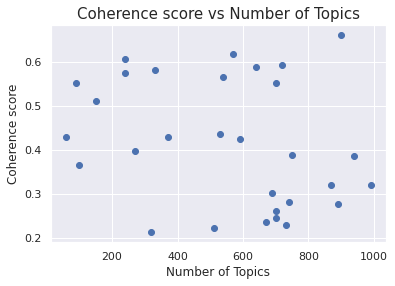

In [ ]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots()
ax.scatter(test.Topics, test.Train_cv_score, marker="o")
ax.set_xlabel("Number of Topics")
ax.set_ylabel("Coherence score")
ax.set_title("Coherence score vs Number of Topics", size = 15)
plt.show()

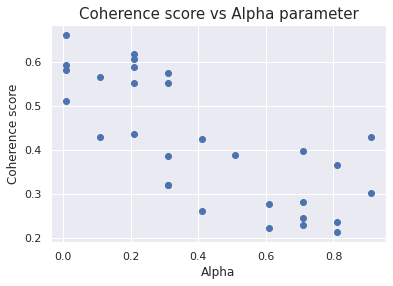

In [ ]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots()
ax.scatter(test.Alpha, test.Train_cv_score, marker="o")
ax.set_xlabel("Alpha")
ax.set_ylabel("Coherence score")
ax.set_title("Coherence score vs Alpha parameter", size = 15)
plt.show()


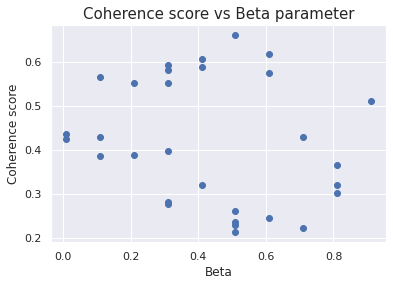

In [ ]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots()
ax.scatter(test.Beta, test.Train_cv_score, marker="o")
ax.set_xlabel("Beta")
ax.set_ylabel("Coherence score")
ax.set_title("Coherence score vs Beta parameter", size = 15)
plt.show()



In [ ]:
test

Topics  Alpha  Beta  Train_cv_score
8905     900   0.01  0.51        0.662329
5626     570   0.21  0.61        0.617760
2324     240   0.21  0.41        0.607432
7103     720   0.01  0.31        0.592470
6324     640   0.21  0.41        0.588314
3203     330   0.01  0.31        0.581628
2336     240   0.31  0.61        0.576168
5311     540   0.11  0.11        0.566518
832       90   0.31  0.21        0.552594
6923     700   0.21  0.31        0.551608
1409     150   0.01  0.91        0.512239
5220     530   0.21  0.01        0.435431
3691     370   0.91  0.11        0.429802
517       60   0.11  0.71        0.429148
5840     590   0.41  0.01        0.424750
2673     270   0.71  0.31        0.398250
7452     750   0.51  0.21        0.387551
9331     940   0.31  0.11        0.386366
988      100   0.81  0.81        0.365326
9838     990   0.31  0.81        0.321183
8634     870   0.31  0.41        0.321171
6898     690   0.91  0.81        0.301868
7373     740   0.71  0.31        0.281187
8863     890   0.61  0.31        0.277695
6945     700   0.41  0.51        0.261294
6976     700   0.71  0.61        0.244241
6685     670   0.81  0.51        0.235626
7275     730   0.71  0.51        0.229015
5067     510   0.61  0.71        0.221050
3185     320   0.81  0.51        0.212087

## 2.2 LDA optimisé

### Définition du model

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=900, 
                                       random_state=100,
                                       chunksize=1000,
                                       passes=10,
                                       alpha=0.01,
                                       eta=0.51)

In [ ]:
filename7 = '/content/drive/MyDrive/Colab_Notebooks/P06/best_ldamodel.pkl'
pickle.dump(lda_model, open(filename7, 'wb'))
filename8 = '/content/drive/MyDrive/Colab_Notebooks/P06/corpus_lda.pkl'
pickle.dump(corpus, open(filename8, 'wb'))
filename9 = '/content/drive/MyDrive/Colab_Notebooks/P06/id2_word.pkl'
pickle.dump(id2word, open(filename9, 'wb'))


##### Visualisation LDAvis

In [ ]:
import pickle
filename7 = '/content/drive/MyDrive/Colab_Notebooks/P06/best_ldamodel.pkl'
with open(filename7, 'rb') as file:
    lda_model = pickle.load(file)
filename8 = '/content/drive/MyDrive/Colab_Notebooks/P06/corpus_lda.pkl'
with open(filename8, 'rb') as file:
    corpus = pickle.load(file)
filename9 = '/content/drive/MyDrive/Colab_Notebooks/P06/id2_word.pkl'
with open(filename9, 'rb') as file:
    id2word = pickle.load(file)

import pyLDAvis.gensim as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word, mds='mmds')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
79    -0.529397 -0.052406       1        1  1.986707
241    0.532242  0.000738       2        1  1.674439
458   -0.259672 -0.467753       3        1  1.602037
670    0.276615 -0.458245       4        1  1.494903
852    0.406950 -0.316454       5        1  1.361828
...         ...       ...     ...      ...       ...
431    0.010498  0.009225     896        1  0.025194
171    0.010498  0.009225     897        1  0.025194
575    0.010498  0.009225     898        1  0.025194
168    0.010498  0.009225     899        1  0.025194
711    0.010498  0.009225     900        1  0.025194

[900 rows x 5 columns], topic_info=           Term          Freq         Total  Category  logprob  loglift
117        file  12488.000000  12488.000000   Default  30.0000  30.0000
42         java   7571.000000   7571.000000   Default  29.0000  29.0000
5         value   8005.000000   8005.000000   Default  28.0000  28.0000
68      problem   6537.000000   6537.000000   Default  27.0000  27.0000
73     function   7982.000000   7982.000000   Default  26.0000  26.0000
...         ...           ...           ...       ...      ...      ...
1487  highlight      0.158328    277.248930  Topic900  -7.7156   0.8183
1486     taking      0.158328    523.655808  Topic900  -7.7156   0.1824
1485    someone      0.158328   1929.212989  Topic900  -7.7156  -1.1216
1484         cv      0.158328    242.102190  Topic900  -7.7156   0.9539
1483   iterator      0.158328    292.480325  Topic900  -7.7156   0.7648

[45057 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1697    238  0.210086  absolute
1428      8  0.103103  abstract
1428     10  0.003682  abstract
1428     11  0.003682  abstract
1428     28  0.003682  abstract
...     ...       ...       ...
1282    392  0.003923      zone
1282    458  0.003923      zone
1282    493  0.003923      zone
1074    387  0.209435      zoom
1074    470  0.014199      zoom

[28982 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[80, 242, 459, 671, 853, 801, 719, 744, 477, 312, 867, 567, 778, 703, 347, 132, 220, 474, 514, 553, 636, 701, 246, 682, 595, 896, 602, 217, 247, 496, 404, 309, 539, 319, 738, 702, 840, 43, 230, 518, 868, 475, 793, 763, 711, 334, 864, 204, 764, 315, 186, 820, 338, 268, 661, 791, 505, 809, 705, 264, 695, 506, 638, 461, 792, 612, 874, 699, 45, 393, 322, 463, 851, 357, 239, 804, 693, 900, 146, 873, 345, 564, 857, 583, 127, 603, 677, 644, 529, 177, 777, 460, 659, 556, 618, 426, 844, 807, 316, 241, 714, 20, 734, 210, 598, 766, 685, 228, 219, 468, 231, 402, 153, 649, 578, 614, 211, 501, 278, 98, 623, 481, 473, 789, 495, 871, 760, 545, 27, 630, 167, 354, 373, 669, 2, 554, 611, 38, 119, 483, 679, 123, 537, 645, 190, 59, 558, 7, 530, 223, 135, 3, 206, 543, 295, 344, 883, 67, 812, 575, 418, 355, 452, 92, 420, 22, 646, 350, 507, 652, 134, 197, 286, 34, 751, 314, 17, 234, 313, 113, 739, 464, 609, 173, 156, 107, 101, 299, 331, 471, 136, 787, 72, 894, 145, 341, 71, 639, 560, 236, 77, 735, 672, 391, 259, 706, 61, 768, 877, 178, 203, 862, 591, 725, 773, 306, 823, 866, 396, 260, 666, 872, 195, 541, 78, 25, 24, 637, 837, 353, 531, 58, 104, 333, 443, 526, 664, 97, 718, 547, 42, 303, 499, 600, 249, 825, 215, 726, 552, 207, 5, 881, 431, 53, 229, 629, 656, 761, 875, 212, 158, 298, 412, 161, 181, 601, 275, 261, 779, 660, 858, 122, 269, 548, 4, 743, 294, 588, 533, 386, 397, 790, 570, 302, 170, 608, 534, 673, 826, 50, 175, 154, 480, 658, 631, 433, 150, 417, 235, 16, 258, 523, 697, 253, 356, 898, 12, 446, 159, 21, 390, 383, 549, 54, 296, 41, 436, 271, 643, 597, 317, 831, 282, 796, 274, 487, 392, 398, 617, 44, 214, 413, 129, 284, 621, 185, 340, 233, 46, 590, 328, 362, 870, 527, 307, 375, 803, 745, 709, 832, 492, 194, 780, 653, 336, 371, 786, 606, 771, 221, 369, 758, 84, 183, 569, 731, 544, 86, 165, 189, 769, 139, 895

In [ ]:
top_topics = lda_model.top_topics(corpus)
from pprint import pprint
pprint(top_topics)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
   (0.00045740863, 'efficiency')],
  -12.720594207774248),
 ([(0.067311205, 'organization'),
   (0.05866168, 'interpolation'),
   (0.020817004, 'concat'),
   (0.0018912804, 'interval'),
   (0.0011355804, 'lost'),
   (0.0010773613, 'complicated'),
   (0.00083050993, 'spam'),
   (0.0007906144, 'modified'),
   (0.0007511264, 'execute'),
   (0.00074854714, 'factor'),
   (0.00074208644, 'perform'),
   (0.0007279345, 'win'),
   (0.0006344324, 'advanced'),
   (0.0006202379, 'unique'),
   (0.00058155425, 'insertion'),
   (0.000550671, 'hyperlink'),
   (0.0005314931, 'mask'),
   (0.0005309022, 'concatenating'),
   (0.0005172261, 'retrieving'),
   (0.0005160672, 'advice')],
  -12.721001899333618),
 ([(0.113109, 'replacement'),
   (0.0012970946, 'plug'),
   (0.00063463557, 'captcha'),
   (0.0005555178, 'retain'),
   (0.0005427824, 'see'),
   (0.00052765565, 'prepared'),
   (0.00048353188, 'slow'),
   (0.00047973005, 'sp

##### Mise sous fonction du modèle, et de différentes mesures de pertinence

In [ ]:
## Fonction servant à mesurer un taux de représentativité du résultat par rapport à un élément source comme le Titre

def is_in_source(Tags,Source_to_compare):
  A = Tags#.tolist()
  if len(A)>0:
    B = Source_to_compare
    C = 0
    D = len(A)
    for i in A:
      if i in B:
        C=C+1
    score = C/D
  else :
    score = 0
  return score

In [ ]:
# Fonction pipe servant à (Formater), traiter une question + Titre et à prédire des Tags, 
# ainsi que leur probabilité et leur taux de couverture au titre

def get_taggs(title,question,formating):
  if formating == True:
    title = formating_the_doc(title)
    question = formating_the_doc(question)
  important_words = title+question

  dictionary = id2word
  ques_vec = dictionary.doc2bow(important_words)
  topic_vec = lda_model[ques_vec]

  #Create a vec from 0 to ntopic  with p proba
  #Get topic = prob of word in each topic(n),sum=1
  df1 = pd.DataFrame(list(topic_vec), columns=['Topic','Prob'])
  ntopc = lda_model.get_topics().shape[0]
  df2 = pd.DataFrame({'Topic':np.arange(0,ntopc),'Prob':[0]*ntopc})
  topicvec = np.array(pd.concat([df1, df2]).groupby(['Topic']).sum().reset_index()['Prob'])

  #prob of topic * prob of word in topic (keeping 5 best proba ? or limit proba ?)
  vec_taggs_prob = pd.DataFrame(np.dot(np.transpose(lda_model.get_topics()),topicvec)).sort_values(0,ascending=False).head(5)
  vec_taggs_prob['tags'] = [dictionary.id2token[i] for i in vec_taggs_prob.index.tolist()]
  score = is_in_source(Tags=vec_taggs_prob['tags'],Source_to_compare=title)
  return vec_taggs_prob,score

In [ ]:
#Demonstration de la fonction : [0] = DataFrame avec 5 taggs précédés de leur probabilité, 
#                               [1] = Taux de couverture du titre

title = df.Title[31]
question = df.Body[31]
get_taggs(title=title,question=question,formating=True)

(             0      tags
 71    0.107824     class
 100   0.058001      base
 220   0.039868   pointer
 1098  0.021445  question
 103   0.020833      type, 0.6)

In [ ]:
# Fonction prédisant 5 Tags par Question Reponse, prédit les probabilités de chaque tagg par question et leur couverture

def transform_unsupervised(table,title_col_name,questions_col_name,formating):
  table['output'] = [get_taggs(title=table[title_col_name][i],question=table[questions_col_name][i],formating=formating) for i in table.index]
  table['proposed_tags'] = [table['output'][i][0]['tags'].tolist() for i in table['output'].index]
  table['probs'] = [table['output'][i][0][0].tolist() for i in table['output'].index]
  table['tagsintilte']=[table['output'][i][1] for i in table['output'].index]
  table.drop(columns='output',inplace=True)
  return table.head(5)

In [ ]:
#  Comparaison entre des temps de traitement avec en entrée des entrées préformatées ou non préformatées. 
#  Le temps est donnée pour prédiction du df(train)
import time
dr = df[0:500]

start_time = time.time()
transform_unsupervised(dr,'Tit_lemmatized2','d_lemmatized2',False)
a = (time.time() - start_time)
print("No formatting --- %s seconds ---" % a)
print(((len(df))/(len(dr)/a))/60,' estimated time in min')
print('\n','-'*50,'\n')

start_time = time.time()
transform_unsupervised(dr,'Title','descr',True)
a = (time.time() - start_time)
print("Formatting --- %s seconds ---" % a)
print(((len(df))/(len(dr)/a))/60,' estimated time in min')

No formatting --- 15.477149963378906 seconds ---
25.68690988922119  estimated time in min

 -------------------------------------------------- 

Formatting --- 17.91718888282776 seconds ---
29.736561149199805  estimated time in min


#####  Tranformation & Résultats

In [ ]:
transform_unsupervised(df,'Tit_lemmatized2','d_lemmatized2',False)

index        Id  PostTypeId  AcceptedAnswerId  ParentId  \
0  118495  24991065           1        24991268.0       NaN   
1   56939  44816980           1               NaN       NaN   
2  118092  25099334           1               NaN       NaN   
3  117472  25282442           1        25282770.0       NaN   
4    9039  63498813           1        63499784.0       NaN   

          CreationDate  DeletionDate  Score  ViewCount  \
0  2014-07-28 08:20:23           NaN      7        250   
1  2017-06-29 05:28:43           NaN      1       1381   
2  2014-08-02 20:55:43           NaN      1        121   
3  2014-08-13 09:16:28           NaN      1       2953   
4  2020-08-20 05:28:10           NaN      1        159   

                                                Body  OwnerUserId  \
0  <p>I think <a href="https://stackoverflow.com/...    3879007.0   
1  <p>I have two arrays in a bash script, every a...    3277018.0   
2  <p>I am working with <a href="http://sandbox.s...    3142680.0   
3  <p>Usually, there is only one instance of a sp...    4551155.0   
4  <p>Here's my code but my answer is not that wh...   11340737.0   

  OwnerDisplayName  LastEditorUserId LastEditorDisplayName  \
0              NaN              -1.0                   NaN   
1              NaN               NaN                   NaN   
2              NaN         3880179.0                   NaN   
3              NaN               NaN                   NaN   
4              NaN        11340737.0                   NaN   

          LastEditDate     LastActivityDate  \
0  2017-05-23 12:33:57  2014-07-28 09:10:38   
1                  NaN  2017-06-29 05:45:16   
2  2014-08-03 04:29:03  2014-08-03 04:34:55   
3                  NaN  2014-08-14 07:03:43   
4  2020-08-26 07:12:02  2020-10-28 06:22:39   

                                               Title  \
0  Returning const values to leverage move semant...   
1  How to use two arrays in a shell script for loop?   
2  jQuery Spritely plugin not work with jQuery + ...   
3  How can only one servlet instance exist in mul...   
4  Using forEach Loop Generating prime number in ...   

                                        Tags  AnswerCount  CommentCount  \
0   [operator, overloading, move, semantics]            1             3   
1               [arrays, linux, bash, shell]            2             4   
2            [javascript, jquery, html, css]            1             2   
3   [java, multithreading, tomcat, servlets]            2             5   
4  [javascript, php, html, jquery, function]            4            10   

   FavoriteCount           ClosedDate CommunityOwnedDate ContentLicense  lenT  \
0            1.0  2014-07-28 09:04:14                NaN   CC BY-SA 3.0     4   
1            NaN  2017-06-29 05:45:23                NaN   CC BY-SA 3.0     4   
2            NaN  2014-08-03 04:40:07                NaN   CC BY-SA 3.0     4   
3            NaN  2014-08-14 07:21:33                NaN   CC BY-SA 3.0     4   
4            NaN  2020-08-20 22:16:35                NaN   CC BY-SA 4.0     5   

                                               descr  \
0  i think this question was slightly misundersto...   
1  i have two arrays in a bash script, every arra...   
2  i am working with jquery spritely plugin for m...   
3  usually, there is only one instance of a speci...   
4  here's my code but my answer is not that which...   

                                              descr1  \
0  [think, question, slightly, misunderstood, ret...   
1  [two, arrays, bash, script, every, array, numb...   
2  [working, jquery, spritely, plugin, moving, cl...   
3  [usually, one, instance, specific, servlet, co...   
4  [code, answer, want, please, check, give, solu...   

                                        d_lemmatized  \
0  [think, question, slightly, misunderstood, ret...   
1  [two, array, bash, script, every, array, numbe...   
2  [working, jquery, spritely, plugin, moving, cl...   
3  [usually, one, instance, spec

In [ ]:
df['tagsintilte'].mean()

0.3437678248644892

In [ ]:
df[['Title','Tags','proposed_tags','tagsintilte','probs']].sample(10)

Title  \
136    UILabel/UITextField doesn't update with asynch...   
9469      php, retrieve the password of the current user   
22195  How can I create h:selectOneRadio with options...   
46167           python script to operate windows program   
31814  Java library for keywords extraction from inpu...   
44899                  Ways to refresh a page in browser   
10990                 Sequel Pro Alternative for Windows   
13346  Sockets,BufferedWriter.flush() not sending the...   
11981                                 OCL Syntax Checker   
8939   How to add launch parameter to Google Chrome o...   

                                                 Tags  \
136                       [ios, swift, http, request]   
9469                [php, windows, active, directory]   
22195            [forms, jsf, jsf, primefaces, radio]   
46167                  [python, windows, macros, exe]   
31814                   [java, nlp, extract, keyword]   
44899  [javascript, backbone, js, javascript, events]   
10990               [mysql, windows, user, interface]   
13346   [java, sockets, bufferedreader, serversocket]   
11981               [java, syntax, open, source, uml]   
8939             [macos, google, chrome, applescript]   

                                  proposed_tags  tagsintilte  \
136          [request, method, http, com, text]          0.4   
9469   [user, php, application, file, password]          0.6   
22195      [list, java, element, value, change]          0.4   
46167       [window, python, file, script, jar]          0.6   
31814  [java, library, word, integer, language]          0.2   
44899    [page, question, browser, event, list]          0.4   
10990       [window, work, client, system, sql]          0.2   
13346      [string, server, line, work, socket]          0.2   
11981     [tool, syntax, code, object, eclipse]          0.2   
8939         [parameter, run, pas, mac, google]          0.6   

                                                   probs  
136    [0.07790212685728623, 0.06631066656974142, 0.0...  
9469   [0.10479416171256696, 0.0677475823150733, 0.03...  
22195  [0.07186492852686069, 0.061421349600127746, 0....  
46167  [0.0514565313160651, 0.04651268706809242, 0.03...  
31814  [0.05462757640842996, 0.039568199631621635, 0....  
44899  [0.14839144651114872, 0.035057607710950074, 0....  
10990  [0.14411674864745103, 0.06477245180607655, 0.0...  
13346  [0.10532596147264346, 0.045806159005902874, 0....  
11981  [0.0757554969906646, 0.03543716556306666, 0.03...  
8939   [0.054100202848800544, 0.04150125169955707, 0....

In [ ]:
# Calcul du taux de couverture sur les Tags déjà existant : 
df['Lemmatized_tags'] = [[lem.lemmatize(token) for token in doc] for doc in df['Tags']]

df['is_in_Tags'] = [is_in_source(Tags=df['proposed_tags'][i],Source_to_compare=df['Lemmatized_tags'][i]) for i in df.index]

transform_unsupervised(df_test,'Tit_lemmatized2','d_lemmatized2',False)
df_test['Lemmatized_tags'] = [[lem.lemmatize(token) for token in doc] for doc in df_test['Tags']]
df_test['is_in_Tags'] = [is_in_source(Tags=df_test['proposed_tags'][i],Source_to_compare=df_test['Lemmatized_tags'][i]) for i in df_test.index]

In [ ]:
print('Couverture des tags proposés dans les tags existants','\n')

print('Cover : Proposed tags / Tags from Train set',df.is_in_Tags.mean())
print('-'*65)
print('Cover : Proposed tags / Tags from Test set',df_test.is_in_Tags.mean())
print('\n','-'*100,'\n')
print('Couverture des tags proposés dans les mots du titre','\n')
print('Cover : Proposed tags / Title from Train set',df.tagsintilte.mean())
print('-'*65)
print('Cover : Proposed tags / Title from Test set',df_test.tagsintilte.mean())

Couverture des tags proposés dans les tags existants 

Cover : Proposed tags / Tags from Train set 0.1891906005221586
-----------------------------------------------------------------
Cover : Proposed tags / Tags from Test set 0.18883354755784967

 ---------------------------------------------------------------------------------------------------- 

Couverture des tags proposés dans les mots du titre 

Cover : Proposed tags / Title from Train set 0.3437678248644892
-----------------------------------------------------------------
Cover : Proposed tags / Title from Test set 0.3443123393316057


# 3. Modélisation Supervisée

## 3.1 Tests de différents modèles

### 3.1.1 Préparation des données Train / test

In [ ]:
X_train = [" ".join(bow) for bow in df['BOW']]

y_train = [tuple(doc) for doc in df['Tags']]

X_test = [" ".join(bow) for bow in df_test['BOW']]

y_test = [tuple(doc) for doc in df_test['Tags']]

### 3.1.2 Multilabel Binarizer

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()

y_train = multilabel_binarizer.fit_transform(y_train)

filename3 = '/content/drive/MyDrive/Colab_Notebooks/P06/MultilabelBina.pkl'
pickle.dump(multilabel_binarizer, open(filename3, 'wb'))

y_test = multilabel_binarizer.transform(y_test)



### 3.1.3 TFIDF Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_X = TfidfVectorizer(analyzer = 'word', 
                                     min_df=0.0,
                                    max_df = 1.0,
                                    strip_accents = None,
                                    encoding = 'utf-8', 
                                    preprocessor=None,
                                    token_pattern=r"(?u)\S\S+",
                                    max_features=1000)

In [ ]:
X_train = vectorizer_X.fit_transform(X_train)

filename4 = '/content/drive/MyDrive/Colab_Notebooks/P06/Vectorizer.pkl'
pickle.dump(vectorizer_X, open(filename4, 'wb'))

X_test = vectorizer_X.transform(X_test)

### 3.1.4 Score Jacard

In [ ]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("---")   

### 3.1.5 Test des modèles

In [ ]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

arr={'Classifier':['Dummy','SGD','LogisticReg','Linear SVC','Perceptron','Passive Agress'],'Score':[],'Time':[]}
for classifier in [dummy, sgd, lr, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    start_time = time.time()
    clf.fit(X_train, y_train)
    a = (time.time() - start_time)/60
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)
    sc = avg_jacard(y_test, y_pred)
    arr['Score'].append(sc)
    arr['Time'].append(a)

arr = pd.DataFrame(arr)
filename5 = '/content/drive/MyDrive/Colab_Notebooks/P06/Results_models_clf.pkl'
pickle.dump(arr, open(filename5, 'wb'))

In [ ]:
pd.DataFrame(arr)

Classifier      Score      Time
0           Dummy   1.665235  0.264603
1             SGD  21.161097  2.273541
2     LogisticReg  23.802335  7.851271
3      Linear SVC  27.077503  3.905597
4      Perceptron  22.814392  2.637131
5  Passive Agress  28.212692  2.894573

Sélection et optimisation du modèle Passive Agressive Classifier (Meilleurs résultats en terme de score jacquard et de temps

## 3.2 Passive Agressive Classifier

### 3.2.1 GridSearchCV

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import make_scorer

my_func = make_scorer(avg_jacard, greater_is_better=True)

param_grid = {"estimator__C": [0.2,0.5,1,2]}

clf = OneVsRestClassifier(PassiveAggressiveClassifier(random_state=1))

model = GridSearchCV(clf,param_grid, cv=3,n_jobs=-1,scoring=my_func)

model.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=OneVsRestClassifier(estimator=PassiveAggressiveClassifier(C=1.0,
                                                                                 average=False,
                                                                                 class_weight=None,
                                                                                 early_stopping=False,
                                                                                 fit_intercept=True,
                                                                                 loss='hinge',
                                                                                 max_iter=1000,
                                                                                 n_iter_no_change=5,
                                                                                 n_jobs=None,
                                                                                 random_st

In [ ]:
pd.DataFrame(model.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     193.313023      0.426503         3.826532        0.015498   
1     219.058503     20.394650         3.578755        0.188762   
2     240.482917      6.430499         3.564408        0.382956   
3     259.409214      3.640644         2.626428        0.447218   

  param_estimator__C                 params  split0_test_score  \
0                0.2  {'estimator__C': 0.2}          26.280393   
1                0.5  {'estimator__C': 0.5}          28.000521   
2                  1    {'estimator__C': 1}          27.463528   
3                  2    {'estimator__C': 2}          25.624751   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0          26.775665          26.648506        26.568188        0.210019   
1          28.627245          28.211239        28.279668        0.260394   
2          28.009214          27.862456        27.778400        0.230568   
3          26.210002          25.819174        25.884643        0.243371   

   rank_test_score  
0                3  
1                1  
2                2  
3                4

### 3.2.2 Best Model

In [ ]:
bestmodel = OneVsRestClassifier(PassiveAggressiveClassifier(random_state=1,C=model.best_params_['estimator__C']))
bestmodel.fit(X_train, y_train)
filename6 = '/content/drive/MyDrive/Colab_Notebooks/P06/Best_Classifier.pkl'
pickle.dump(bestmodel, open(filename6, 'wb'))

### 3.2.3 Résultats et prédictions

In [ ]:
y_pred = model.predict(X_test)
Ltags = multilabel_binarizer.inverse_transform(y_pred)
df_test['TagsPAC']=Ltags

y_pred = model.predict(X_train)
Ltags = multilabel_binarizer.inverse_transform(y_pred)
df['TagsPAC']=Ltags

In [ ]:
df_test[['Tags','Title','TagsPAC','proposed_tags']]

Tags  \
126255            [javascript, jquery, arrays, undefined]   
168725                  [ios, objective, keyboard, first]   
154135                     [browser, web, engine, engine]   
66631         [javascript, node, js, debugging, phpstorm]   
243493                     [java, datetime, parsing, nlp]   
...                                                   ...   
14244   [android, firebase, firebase, realtime, database]   
178892          [multithreading, task, parallel, library]   
221004       [java, user, interface, networking, diagram]   
142070                      [java, arrays, loops, object]   
187220                     [arrays, struct, linked, list]   

                                                    Title  \
126255                 why is array undefined in my code?   
168725              iOS dismiss keyboard but keep editing   
154135        Creating web based football simulation game   
66631                             How can I debug Node.js   
243493     Natural Language date and time parser for java   
...                                                   ...   
14244   Activity has leaked window Already logged in t...   
178892  Differences between multithreading and multita...   
221004         How to create a network picture Using Java   
142070         "for" loop does not iterate the way I want   
187220            linked list array being different sizes   

                      TagsPAC                              proposed_tags  
126255              (arrays,)         [array, code, show, problem, case]  
168725        (ios, keyboard)     [view, app, keep, keyboard, scrolling]  
154135              (canvas,)     [application, game, feature, run, web]  
66631   (debugging, js, node)              [tool, j, server, step, node]  
243493  (date, java, parsing)       [date, java, output, language, time]  
...                       ...                                        ...  
14244     (android, firebase)       [problem, page, error, case, called]  
178892      (multithreading,)  [program, number, task, difference, code]  
221004     (java, networking)       [image, network, java, device, host]  
142070               (loops,)        [class, object, number, work, make]  
187220              (arrays,)         [order, array, size, output, code]  

[12448 rows x 4 columns]

In [ ]:
df['Sup_Tags_is_in_Tags'] = [is_in_source(Tags=df['TagsPAC'][i],Source_to_compare=df['Tags'][i]) for i in df.index]
df_test['Sup_Tags_is_in_Tags'] = [is_in_source(Tags=df_test['TagsPAC'][i],Source_to_compare=df_test['Tags'][i]) for i in df_test.index]

In [ ]:
df['Sup_Tags_is_in_Tit'] = [is_in_source(Tags=df['TagsPAC'][i],Source_to_compare=df['Tit_lemmatized2'][i]) for i in df.index]
df_test['Sup_Tags_is_in_Tit'] = [is_in_source(Tags=df_test['TagsPAC'][i],Source_to_compare=df_test['Tit_lemmatized2'][i]) for i in df_test.index]

### 3.2.4 Couverture Titre / Tags

In [ ]:
print('Couverture des tags proposés dans les tags existants','\n')

print('Cover : Proposed tags / Tags from Train set',df.Sup_Tags_is_in_Tags.mean())
print('-'*65)
print('Cover : Proposed tags / Tags from Test set',df_test.Sup_Tags_is_in_Tags.mean())
print('\n','-'*100,'\n')
print('Couverture des tags proposés dans les mots du titre','\n')
print('Cover : Proposed tags / Title from Train set',df.Sup_Tags_is_in_Tit.mean())
print('-'*65)
print('Cover : Proposed tags / Title from Test set',df_test.Sup_Tags_is_in_Tit.mean())

Couverture des tags proposés dans les tags existants 

Cover : Proposed tags / Tags from Train set 0.7624202603314898
-----------------------------------------------------------------
Cover : Proposed tags / Tags from Test set 0.6052483091565724

 ---------------------------------------------------------------------------------------------------- 

Couverture des tags proposés dans les mots du titre 

Cover : Proposed tags / Title from Train set 0.3926987633776164
-----------------------------------------------------------------
Cover : Proposed tags / Title from Test set 0.3783340601664834


#4. Comparaison des résultats Supervisé / Non supervisé

In [ ]:
pd.DataFrame({'Modèle':['Supervisé (PAC)','Non supervisé'],'Couv Train : Tags sur Titre':[df.Sup_Tags_is_in_Tit.mean(),df.tagsintilte.mean()],'Test :Tags sur Titre':[df_test.Sup_Tags_is_in_Tit.mean(),df_test.tagsintilte.mean()],'Train :Tags sur Tags':[df.Sup_Tags_is_in_Tags.mean(),df.is_in_Tags.mean()],'Test :Tags sur Tags':[df_test.Sup_Tags_is_in_Tags.mean(),df_test.is_in_Tags.mean()]})

Modèle  Couv Train : Tags sur Titre  Test :Tags sur Titre  \
0  Supervisé (PAC)                     0.392699              0.378334   
1    Non supervisé                     0.343768              0.344312   

   Train :Tags sur Tags  Test :Tags sur Tags  
0              0.762420             0.605248  
1              0.189191             0.188834